In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xlrd

In [2]:
DATA_FILE = "data/fire_theft.xls"

In [3]:
# Step 1:read in data from the .xls file
book = xlrd.open_workbook(DATA_FILE, encoding_override="utf-8")
sheet = book.sheet_by_index(0)
data = np.asarray([sheet.row_values(i) for i in range(1, sheet.nrows)])
n_samples = sheet.nrows - 1
print('num of samples is:', n_samples)
print(data)
x_samples, y_samples = data[:, 0], data[:, 1]

('num of samples is:', 42)
[[   6.2   29. ]
 [   9.5   44. ]
 [  10.5   36. ]
 [   7.7   37. ]
 [   8.6   53. ]
 [  34.1   68. ]
 [  11.    75. ]
 [   6.9   18. ]
 [   7.3   31. ]
 [  15.1   25. ]
 [  29.1   34. ]
 [   2.2   14. ]
 [   5.7   11. ]
 [   2.    11. ]
 [   2.5   22. ]
 [   4.    16. ]
 [   5.4   27. ]
 [   2.2    9. ]
 [   7.2   29. ]
 [  15.1   30. ]
 [  16.5   40. ]
 [  18.4   32. ]
 [  36.2   41. ]
 [  39.7  147. ]
 [  18.5   22. ]
 [  23.3   29. ]
 [  12.2   46. ]
 [   5.6   23. ]
 [  21.8    4. ]
 [  21.6   31. ]
 [   9.    39. ]
 [   3.6   15. ]
 [   5.    32. ]
 [  28.6   27. ]
 [  17.4   32. ]
 [  11.3   34. ]
 [   3.4   17. ]
 [  11.9   46. ]
 [  10.5   42. ]
 [  10.7   43. ]
 [  10.8   34. ]
 [   4.8   19. ]]


In [4]:
def huber_loss(y_true, y_pred, max_grad=1.):
    """Calculates the huber loss.

    Parameters
    ----------
    y_true: np.array, tf.Tensor
      Target value.
    y_pred: np.array, tf.Tensor
      Predicted value.
    max_grad: float, optional
      Positive floating point value. Represents the maximum possible
      gradient magnitude.

    Returns
    -------
    tf.Tensor
      The huber loss.
    """
    err = tf.abs(y_true - y_pred, name='abs')
    mg = tf.constant(max_grad, name='max_grad')
    lin = mg*(err-.5*mg)
    quad=.5*err*err
    return tf.where(err < mg, quad, lin)

In [5]:
g1 = tf.Graph()
with g1.as_default():
    # Step 2： create placeholders for input X (number of fire) and label Y 
    # (number of theft)
    X = tf.placeholder(tf.float32, name='X')
    Y = tf.placeholder(tf.float32, name='Y')
    quad_model = tf.placeholder(tf.bool, shape=[], name='quad_model')
    use_huber_loss = tf.placeholder(tf.bool, shape=[], name='use_huber_loss')
    learning_rate = tf.placeholder(tf.float32, shape=[], name='leaning_rate')

    # Step 3: create weight and bias, initializied to 0
    w = tf.Variable(0.0, name='weights_1')
    u = tf.Variable(0.0, name='weights_2')
    b = tf.Variable(0.0, name='bias')

    # Step 4: construt model to predict Y (number of theft) from the number of fire
    Y_predicted = tf.cond(quad_model,lambda: X*X*w + X*u + b, 
                          lambda: X*w + b)

    # Step 5: use the square error or huber loss as the loss funcion
    residual = tf.abs(Y - Y_predicted)
    
    square_loss = tf.reduce_mean(tf.square(residual), name='square_loss')
    
    delta = tf.constant(8.)
    condition = tf.less(residual, delta)
    huber_loss_ = tf.reduce_mean(0.5*tf.square(residual)*tf.cast(condition, tf.float32) + 
        (delta*residual - 0.5*tf.square(delta))*(1 - tf.cast(condition, tf.float32)),
                                name='huber_loss')
    # huber_loss_ = tf.reduce_mean(huber_loss(Y, Y_predicted))
    
    loss = tf.cond(use_huber_loss, lambda: huber_loss_, lambda: square_loss, name='loss')

    # Step 6: using gradient descent with learning rate to minimize loss
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [6]:
class Model_Parameter:
    def __init__(self, w_value=0.0, u_value=0.0, b_value=0.0, use_quad=False, l_list=[]):
        self.w_value = w_value
        self.u_value = u_value
        self.b_value = b_value
        self.use_quad = use_quad
        self.l_list = l_list

In [7]:
def train_model(g, QUAD_MODEL=False, HUBER_LOSS=False):
    if QUAD_MODEL:
        lr = 0.0000007
    else:
        lr = 0.001

    with tf.Session(graph=g) as sess:
        # Step 7: initialize the necessary variables, in this case, w and b
        sess.run(tf.global_variables_initializer())
        
        writer = tf.summary.FileWriter('./my_graph/03/linear_reg', sess.graph)

        # Step 8: train the model
        l_list = []
        for i in range(100): # run 100 epochs
            #for x, y in data:
            sess.run(optimizer,feed_dict={X: x_samples, Y: y_samples, 
                                          quad_model: QUAD_MODEL, 
                                          learning_rate:lr,
                                          use_huber_loss: HUBER_LOSS})
            l = sess.run(loss, 
                    feed_dict={X: x_samples,
                               Y: y_samples,
                               quad_model: QUAD_MODEL,
                               use_huber_loss: HUBER_LOSS})
            #print('Epoch {0}: loss {1}'.format(i, l))
            l_list.append(l)

        w_value, u_value, b_value = w.eval(), u.eval(), b.eval()
        print('{0} is {1}'.format(w.name, w_value))
        print('{0} is {1}'.format(u.name, u_value))
        print('{0} is {1}'.format(b.name, b_value))
        print('{} is {}'.format(loss.name, 
              sess.run(loss, 
                       feed_dict={X: x_samples,
                                  Y: y_samples,
                                  quad_model: QUAD_MODEL,
                                  use_huber_loss: HUBER_LOSS})))
        params = Model_Parameter(w_value=w_value,
                                 u_value=u_value,
                                 b_value=b_value,
                                 use_quad=QUAD_MODEL,
                                 l_list=l_list)
        
        writer.close()
        return params

In [8]:
def plot_result(params):
    w_value = params.w_value
    u_value = params.u_value
    b_value = params.b_value
    use_quad = params.use_quad
    l_list = params.l_list
    
    real_data = plt.scatter(x_samples, y_samples, label='Real data')
    x_line = np.linspace(np.min(x_samples), np.max(x_samples), x_samples.shape[0])
    if use_quad:
        y_line = x_line * x_line * w_value + x_line * u_value + b_value
    else:
        y_line = x_line * w_value + b_value
    predict_data = plt.plot(x_line, y_line, label='Predict data', color='r')
    plt.legend()
    plt.xticks(list(range(0, 41, 5)))
    plt.yticks(list(range(0, 161, 20)))
    plt.xlabel('fire')
    plt.ylabel('theft')
    plt.show()
    
    plt.plot(l_list)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

weights_1:0 is 2.10481905937
weights_2:0 is 0.0
bias:0 is 1.2845107317
loss/Merge:0 is 450.06237793


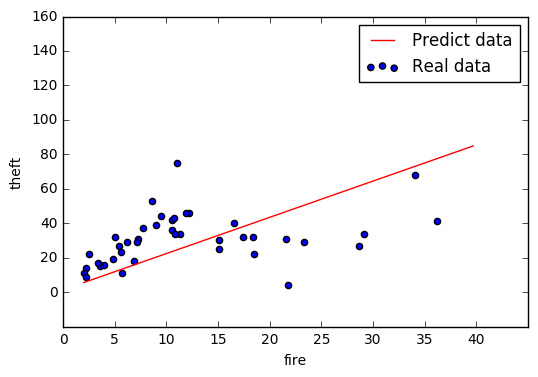

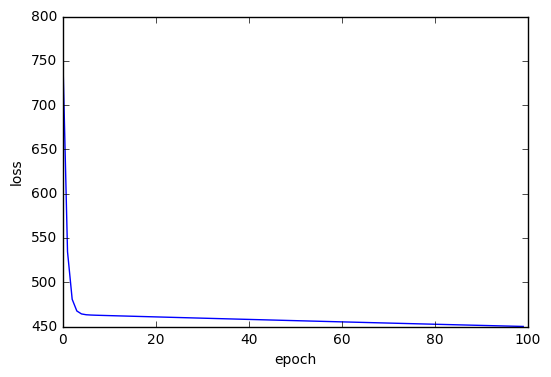

In [9]:
# linear model + MSE
params = train_model(g=g1, QUAD_MODEL=False, HUBER_LOSS=False)
plot_result(params)

weights_1:0 is 0.0672830566764
weights_2:0 is 0.0163921806961
bias:0 is 0.0023974403739
loss/Merge:0 is 735.022644043


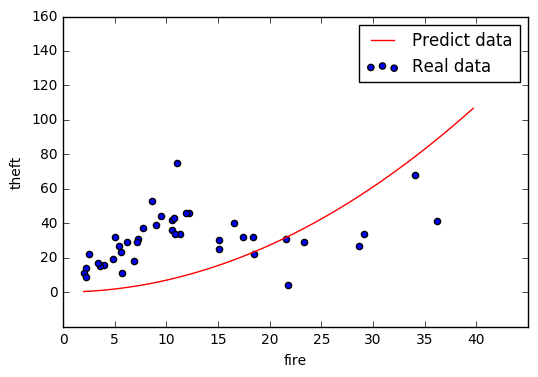

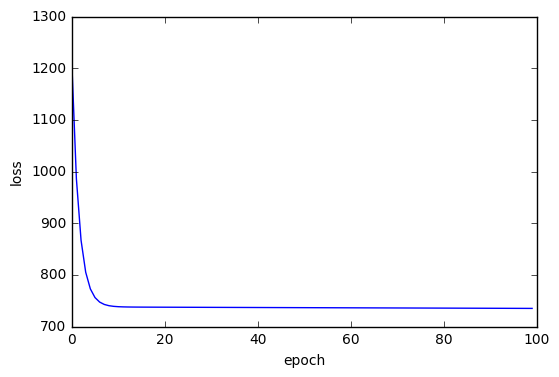

In [10]:
# quadratic model + MSE
params = train_model(g=g1, QUAD_MODEL=True, HUBER_LOSS=False)
plot_result(params)

weights_1:0 is 2.07899904251
weights_2:0 is 0.0
bias:0 is 0.42978823185
loss/Merge:0 is 105.533447266


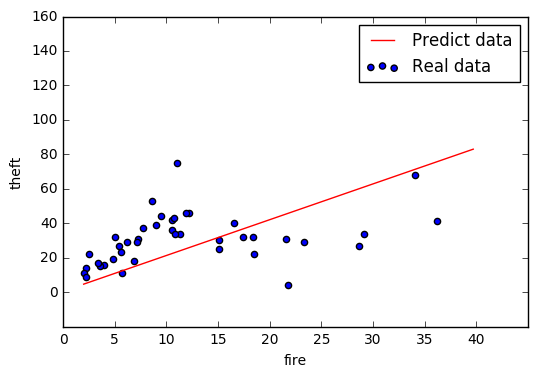

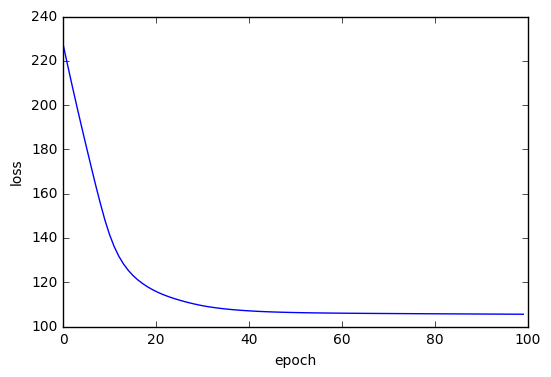

In [11]:
# linear model + huber loss
params = train_model(g=g1, QUAD_MODEL=False, HUBER_LOSS=True)
plot_result(params)

weights_1:0 is 0.0606057345867
weights_2:0 is 0.00430808635429
bias:0 is 0.000458875496406
loss/Merge:0 is 157.971191406


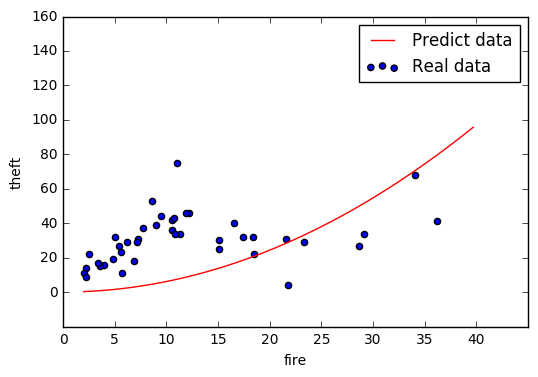

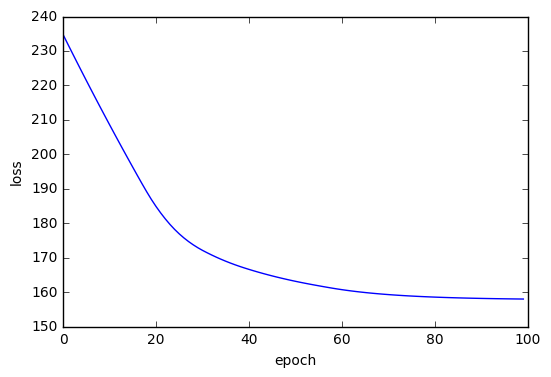

In [12]:
# quardratic model + huber loss
params = train_model(g=g1, QUAD_MODEL=True, HUBER_LOSS=True)
plot_result(params)